### 1. Install R packages

Uncomment section below if running for the first time

In [7]:
# if (!requireNamespace("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")
# BiocManager::install("dada2")
# install.packages("magrittr")
# install.packages("stringr")
# install.packages("data.table")
# install.packages("broom")
# install.packages("qualpalr")
# install.packages("seqinr")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



### 2. Load required libraries

In [9]:
library(dada2)
library(stringr)
library(data.table)
# library(broom)
library(qualpalr)
library(ShortRead)
library(Biostrings)
library(seqinr)

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: BiocParallel

Loading required package: Biostrings

Loading required package: S4Vectors

Loading required package: stats4


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:data.table’:

    first, second


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges


Att

### 3. File path setup

In [17]:
rawpath <- "raw"
wdpath <- "/Users/mann/github/domhain/2022-HIV_oral_microbiome/01-read_processing/" # change to where git repository was cloned
fnFs <- sort(list.files(rawpath, pattern="_R1_001.fastq.gz", full.names=T))
fnRs <- sort(list.files(rawpath, pattern="_R2_001.fastq.gz", full.names=T))
sample.names <- sapply(strsplit(basename(fnFs), "_"), `[`, 1)
head(sample.names, 50)
paste("Number of input samples: ", length(sample.names))

[1] "2L13-PD1"         "2L13-PE1"         "2L13-PF1"         "2L17-PE1"        
 [5] "2L17-PF1"         "2L2-PD1"          "2L2-PE1"          "2L23-PD1"        
 [9] "2L23-PE1"         "2L3-PF1"          "2L4-PF1"          "2L46-PE1"        
[13] "2L46-PF1"         "2L47-PE1"         "2L47-PF1"         "2L49-PF1"        
[17] "2L52-PF1"         "2L59-PF1"         "2L60-PE1"         "2L60-PF1"        
[21] "2L61-PD1"         "2L61-PE1"         "2L61-PF1"         "2L62-PF1"        
[25] "2L63-PE1"         "2L63-PF1"         "2L64-PD1"         "2L64-PE1"        
[29] "2L67-PF1"         "2L69-PF1"         "2L70-PF1"         "2L72-PE1"        
[33] "2L72-PF1"         "2L75-PD1"         "2L75PE1"          "4L59-PF1"        
[37] "DM00001V1PQ"      "DM00002V1PQ"      "DM00004V1PQ55"    "DM00004V1PQ65"   
[41] "DM00005V1PQ36-1"  "DM00005V1PQ46-2"  "DM00006V1PQ1"     "DM00007V1PQ1"    
[45] "DM00008V1PQ16-2"  "DM00008V1PQ26-1"  "DM00009V1PQ55"    "DM00009V1PQ65"   
[49] "DM00010V1PQ54"    "DM00010V1PQ64-65"

[1] "Number of input samples:  918"

### 4. Plot quality scores

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


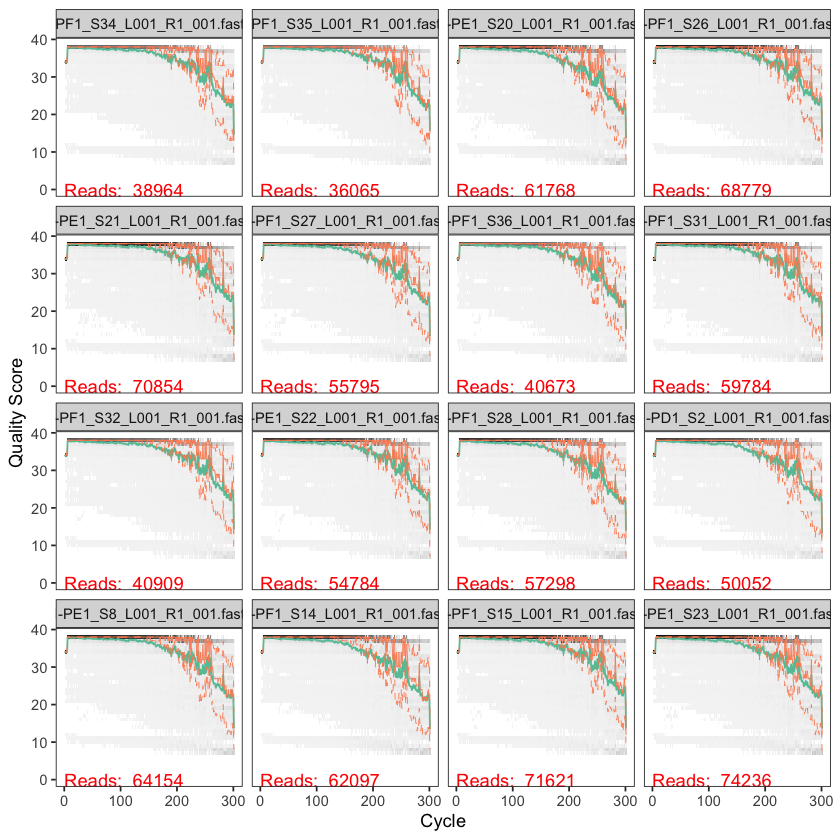

pdf 
  2

pdf 
  2

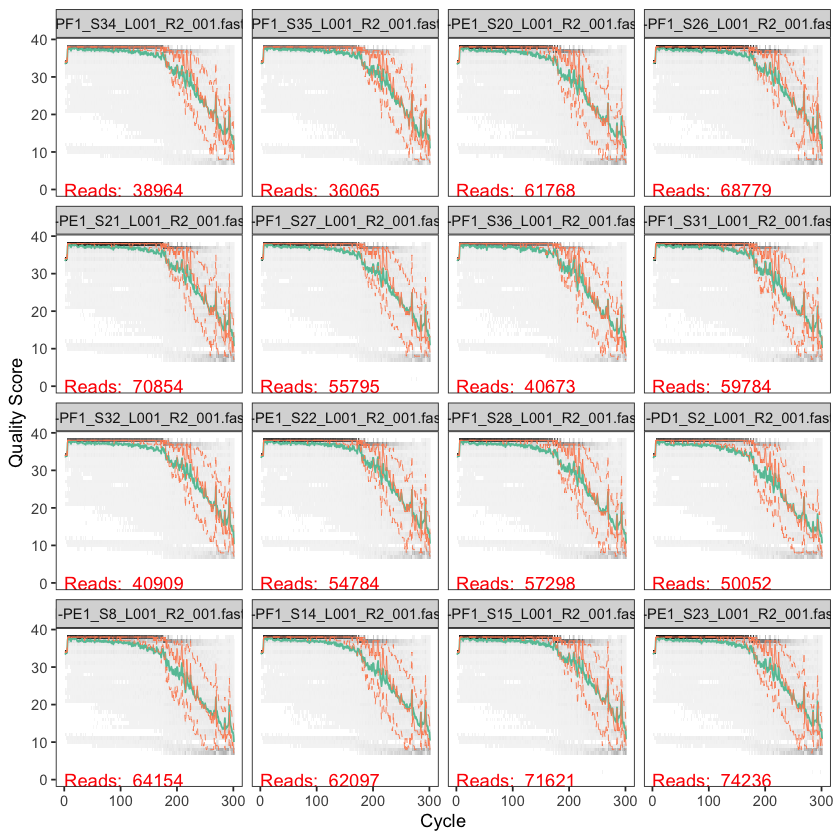

In [20]:
system("mkdir img") # ignore warning
fwdqual <- plotQualityProfile(fnFs[10:25])
revqual <- plotQualityProfile(fnRs[10:25])
fwdqual
revqual

pdf(paste(wdpath, "img/", "forward_quality_plot.pdf", sep=""))
fwdqual
dev.off()
pdf(paste(wdpath, "img/", "reverse_quality_plot.pdf", sep=""))
revqual
dev.off()


### 5. Preliminary filter (removes sequences with uncalled bases)

In [ ]:
fnFs.filtN <- file.path(rawpath, "filtN", basename(fnFs)) # Put N-filterd files in filtN/ subdirectory
fnRs.filtN <- file.path(rawpath, "filtN", basename(fnRs))
filterAndTrim(fnFs, fnFs.filtN, fnRs, fnRs.filtN, maxN = 0, multithread = TRUE, compress = TRUE)

### 6. Primer removal 

In [ ]:
cutadapt <- as.character(system("which cutadapt", intern=T))
system("cutadapt --version")
path.cut <- file.path(rawpath, "cutadapt")
if(!dir.exists(path.cut)) dir.create(path.cut)
fnFs.cut <- file.path(path.cut, basename(fnFs))
fnRs.cut <- file.path(path.cut, basename(fnRs))
FWD.RC <- dada2:::rc("MAYGARAARMGNATGYTNCARGA")
REV.RC <- dada2:::rc("GMCATYTGRTCNCCRTCRAA")
# Trim FWD and the reverse-complement of REV off of R1 (forward reads)
R1.flags <- paste("-g", "MAYGARAARMGNATGYTNCARGA", "-a", REV.RC) 
# Trim REV and the reverse-complement of FWD off of R2 (reverse reads)
R2.flags <- paste("-G", "GMCATYTGRTCNCCRTCRAA", "-A", FWD.RC) 
for(i in seq_along(fnFs)) {
  system2(cutadapt, args = c("--cores=0", R1.flags, R2.flags, "-n", 2,"-o", fnFs.cut[i], "-p", fnRs.cut[i], fnFs.filtN[i], fnRs.filtN[i]))
}
cutFs <- sort(list.files(path.cut, pattern = "R1", full.names = TRUE))
cutRs <- sort(list.files(path.cut, pattern = "R2", full.names = TRUE))

### 7. Filter and trim reads

In [ ]:
filtFs <- file.path(path.cut, "filtered", basename(cutFs))
filtRs <- file.path(path.cut, "filtered", basename(cutRs))
out <- filterAndTrim(cutFs, filtFs, cutRs, filtRs, trimRight=25, maxN=c(0,0), maxEE=c(4,6), rm.phix=TRUE, matchIDs=TRUE, compress=TRUE, multithread=TRUE)
retained <- as.data.frame(out)
retained$percentage_retained <- retained$reads.out/retained$reads.in*100
retained

### 8. Learn and plot error rates

In [ ]:
set.seed(12349)
errF <- learnErrors(filtFs, multithread=T, random=T)
errR <- learnErrors(filtRs, multithread=T, random=T)
err.f.plt <- plotErrors(errF, nominalQ=TRUE) 
err.f.plt
pdf(paste(wdpath, "img/", "error_plot.pdf", sep=""))
err.f.plt
dev.off()

### 9. Dereplication

In [ ]:
derepFs <- derepFastq(filtFs, verbose=TRUE)
derepRs <- derepFastq(filtRs, verbose=TRUE)
# reassign sample names
sample.names <- sapply(strsplit(basename(filtFs), "_"), `[`, 1)
names(derepFs) <- sample.names
names(derepRs) <- sample.names

### 10. Sample inference

In [ ]:
dadaFs <- dada(derepFs, err=errF, multithread=TRUE)
dadaRs <- dada(derepRs, err=errR, multithread=TRUE)

### 11. Merge paired-end reads

In [ ]:
mergers <- mergePairs(dadaFs, derepFs, dadaRs, derepRs, verbose=T)

### 12. Construct sequence table

In [ ]:
seqtab <- makeSequenceTable(mergers)
dim(seqtab)

### 13. Length filter

In [ ]:
table(nchar(colnames(seqtab)))

Filter out any ASVs that are shorter than 450 bp in length

In [ ]:
seqlens <- nchar(getSequences(seqtab))
seqtab.filt <- seqtab[,seqlens >= 450]
dim(seqtab.filt)

### 14. Sequence length distribution post filter

In [ ]:
length.histogram <- as.data.frame(table(nchar(getSequences(seqtab.filt))))
len.plt <- plot(x=length.histogram[,1], y=length.histogram[,2])
len.plt
pdf(paste(wdpath, "img/", "length_hist.pdf", sep=""))
len.plt
dev.off()

### 15. Remove chimeras

In [ ]:
seqtab.nochim <- removeBimeraDenovo(seqtab.filt, method="pooled", multithread=T, verbose=T)
dim(seqtab.nochim)
sum(seqtab.nochim)/sum(seqtab.filt)

### 16. Processing summary

In [ ]:
getN <- function(x) sum(getUniques(x))
track <- cbind(out, sapply(dadaFs, getN), sapply(dadaRs, getN), sapply(mergers, getN), rowSums(seqtab.nochim))
colnames(track) <- c("input", "filtered", "denoisedF", "denoisedR", "merged", "nochimeras")
rownames(track) <- sample.names
track

### 17. Save output

In [ ]:
write.table(data.frame("row_names"=rownames(track),track),"read_retention.txt", row.names=FALSE, quote=F, sep="\t")
uniquesToFasta(seqtab.nochim, "rep_set.fa")
system("awk '/^>/{print \">ASV\" ++i; next}{print}' < rep_set.fa > rep_set_fix.fa")
system("mv rep_set_fix.fa rep_set.fa")

### 18. Clean up ASV names

In [ ]:
my_otu_table <- t(as.data.frame(seqtab.nochim)) 
ASV.seq <- as.character(unclass(row.names(my_otu_table))) 
ASV.num <- paste0("ASV", seq(ASV.seq), sep='') 
colnames(seqtab.nochim) <- ASV.num 
write.table(data.frame("row_names"=rownames(seqtab.nochim),seqtab.nochim),"sequence_table.merged.txt", row.names=FALSE, quote=F, sep="\t")